### Augmentation for Classification

In [ ]:

import warnings
warnings.filterwarnings("ignore")
from keras_preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import os
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
# import tqdm
from PIL import Image



datagen = ImageDataGenerator(
        width_shift_range = 0.2,
        height_shift_range = 0.1,
        horizontal_flip = True,
        shear_range = 0.2,
        brightness_range = (0.7, 1.3),
        zoom_range = 0.1,
        zca_whitening = True,
        fill_mode='constant'
)



INPUT_DIR = "/cluster/home/ammaa/Downloads/FracAtlas/classes images/Fractured"
OUTPUT_DIR = "/cluster/home/ammaa/Downloads/FracAtlas/classes images/Fractured-Aug"

current_transformations = 5
max_imgs = len(os.listdir(INPUT_DIR)) * current_transformations
img_count = 0
    
for file in os.listdir(INPUT_DIR):
    img = Image.open(os.path.join(INPUT_DIR, file))
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    images = []
    for batch in datagen.flow(x, batch_size=1):
        images.append(image.array_to_img(batch[0]))
        i += 1
        if i == current_transformations:
            break
    
    for i in range(0, current_transformations):
        images[i].save(f"{OUTPUT_DIR}/{file[:-4]}-{i}.jpg")
        
    img_count += current_transformations
    if img_count > (max_imgs): break




### Albumentations

In [8]:
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A


BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255) 


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def yolo_to_coco(yolo_coords, image_width, image_height):
    x_center, y_center, width, height = yolo_coords
    x_min = max(0, (x_center - width / 2) * image_width)
    y_min = max(0, (y_center - height / 2) * image_height)
    width = width * image_width
    height = height * image_height
    
    return [x_min, y_min, width, height]


def coco_to_yolo(coco_coords, image_width, image_height):
    x_min, y_min, width, height = coco_coords
    x_center = (x_min + width / 2) / image_width
    y_center = (y_min + height / 2) / image_height
    width = width / image_width
    height = height / image_height
    
    return [x_center, y_center, width, height]
    
def get_image_size(image_path):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    return width, height

In [106]:
coco_to_yolo([1466.6399999999999, 2010.4704000000002, 155.232, 153.4464], image_width, image_height)

[0.5361999999999999, 0.9059, 0.053899999999999997, 0.0666]

In [7]:
img_path = '/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/Augmented_Set/images/IMG0000058.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes = coco_coords
category_ids = [0]

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {0: 'fractured'}

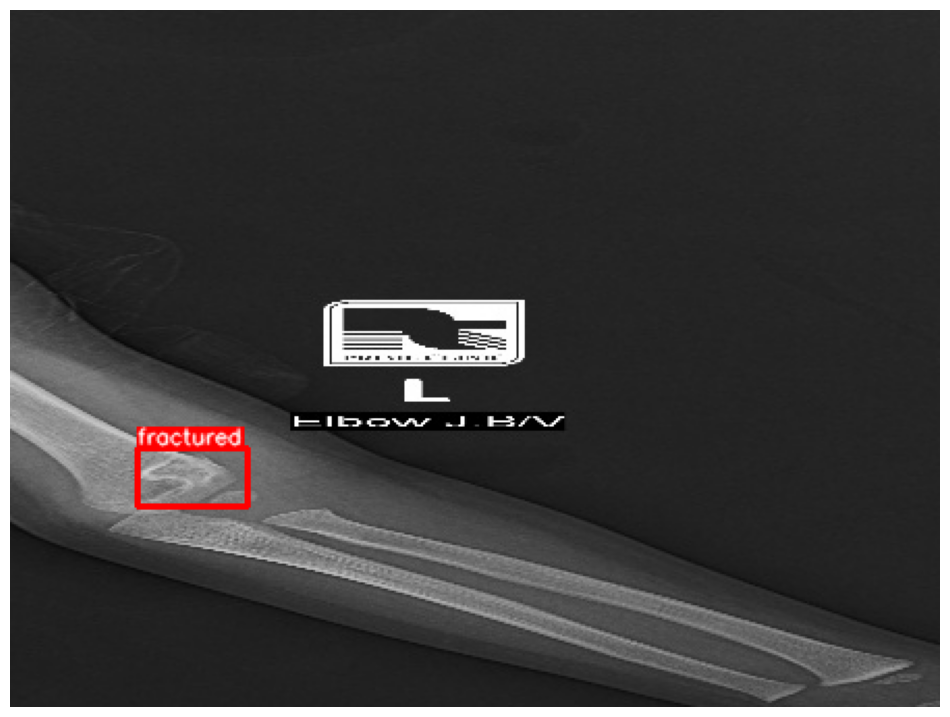

In [9]:
visualize(image, bboxes, category_ids, category_id_to_name)

In [93]:
transform = A.Compose(
    [A.RandomSizedBBoxSafeCrop(width=448, height=336, erosion_rate=0.2)],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

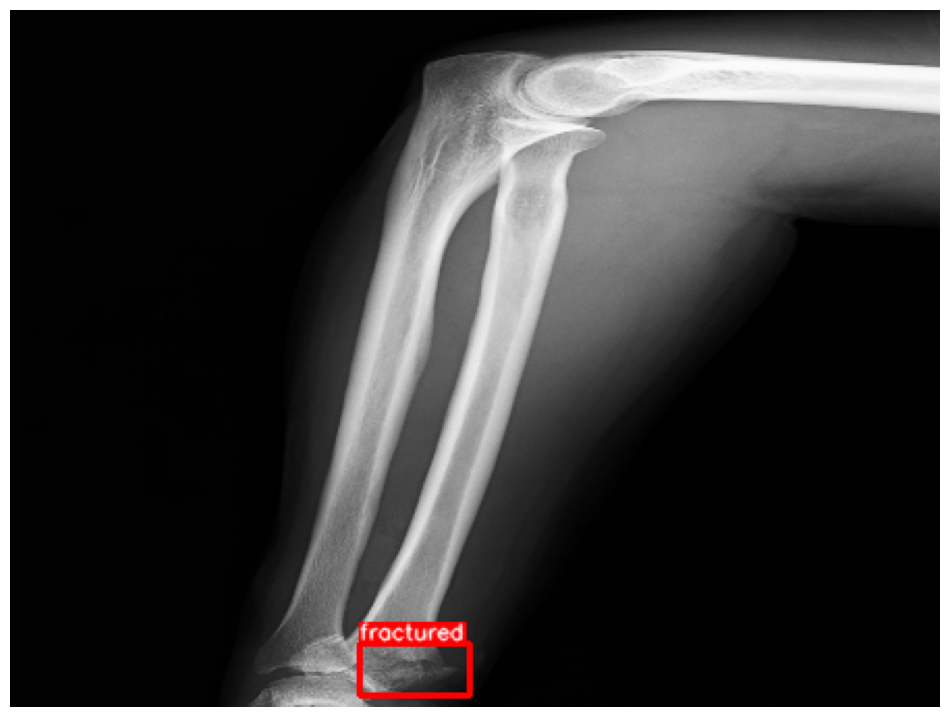

In [61]:
random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

### Augmenting Images with Albumentations

In [15]:
import random
import os
import cv2
from matplotlib import pyplot as plt
import albumentations as A


imgs_dir = "/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/data/Split-Authors/images/train/"
label_dir = "/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/data/Split-Authors/labels/train/"
output_imgs_dir = "/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/Augmented_Set/images"
output_labels_dir = "/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/Augmented_Set/labels"


for i, img in enumerate(os.listdir(imgs_dir)):
    filename = os.path.splitext(os.path.basename(img))[0]
    label_path = os.path.join(label_dir, filename + ".txt")
    yolo_bbox = []

    with open(label_path, 'rb') as label_f:
        for line in label_f:
            line = str(line)
            line = line.replace("\\n'", '')
            line = line.replace("b'", '')
            numbers = line.split(' ')
            x_center, y_center, w, h = float(numbers[1]), float(numbers[2]), float(numbers[3]), float(numbers[4])
            yolo_bbox = [x_center, y_center, w, h]


    image = cv2.imread(os.path.join(imgs_dir, img))
    height, width, _ = image.shape
    coco_bbox = [yolo_to_coco(yolo_bbox, width, height)]
    category_ids = [0]
    category_id_to_name = {0: 'fractured'}
    

    transform = A.Compose(
    [
        # A.RandomSizedBBoxSafeCrop(width=640, height=640, erosion_rate=0.2), 
    A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=1),
    A.HorizontalFlip(p=0.5),
      A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.GaussNoise(),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)


    seed = random.seed(random.randint(0, 100))
    transformed = transform(image=image, bboxes=coco_bbox, category_ids=category_ids)
    transformed_img = transformed['image']
    transformed_bbox = transformed['bboxes']
    transformed_category = transformed['category_ids']


    img = transformed_img.copy()
    yolo_bbox = coco_to_yolo(transformed_bbox[0], img.shape[1], img.shape[0])
    yolo_bbox = [yolo_bbox]

    txt_filename = os.path.join(output_labels_dir, filename + '_' + str(i) + ".txt")
    img_filename = os.path.join(output_imgs_dir, filename + '_' + str(i) + ".jpg")

    with open(txt_filename, "w") as txt_file:
        txt_file.write('0 ')
        for bbox in yolo_bbox:
            txt_file.write(" ".join(str(coord) for coord in bbox) + "\n")

    cv2.imwrite(img_filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


In [13]:
import cv2
import matplotlib.pyplot as plt

def plot_image(img_dir, label_dir):
    image = cv2.imread(img_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = image.copy()
    

    yolo_bbox = []

    with open(label_dir, 'rb') as label_f:
        for line in label_f:
            line = str(line)
            line = line.replace("\\n'", '')
            line = line.replace("b'", '')
            numbers = line.split(' ')
            x_center, y_center, w, h = float(numbers[1]), float(numbers[2]), float(numbers[3]), float(numbers[4])
            yolo_bbox = [x_center, y_center, w, h]


    height, width, _ = img.shape
    bboxes = [yolo_to_coco(yolo_bbox, width, height)]
    category_ids = [0]
    category_id_to_name = {0: 'fractured'}

    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)

    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

IMG0001494_312.jpg IMG0001494_312.txt IMG0001494.jpg IMG0001494.txt


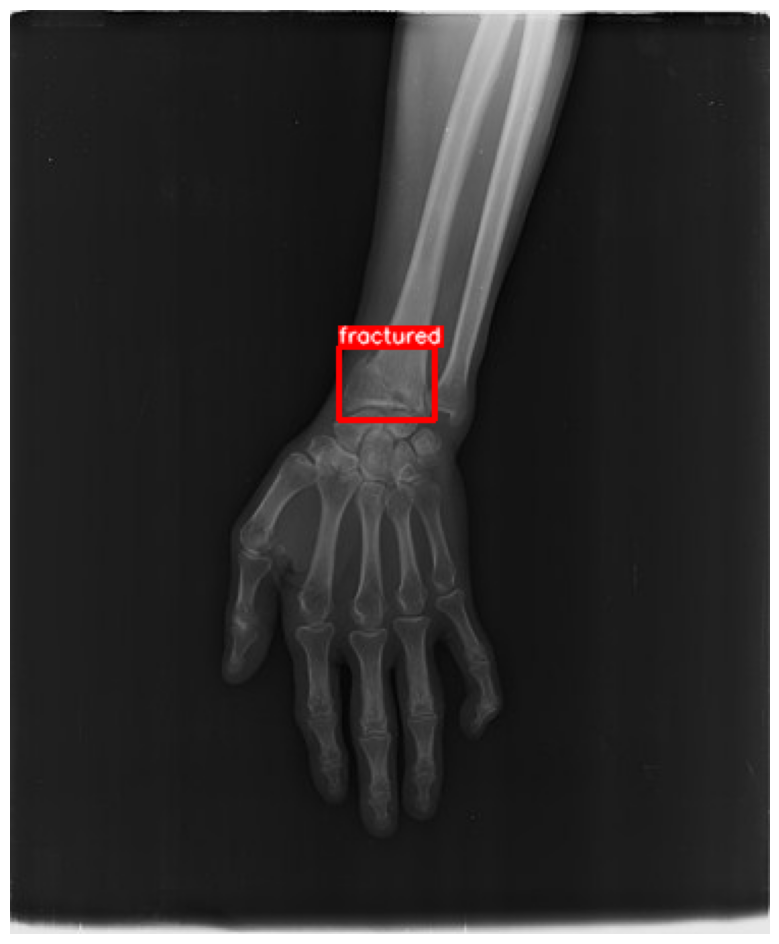

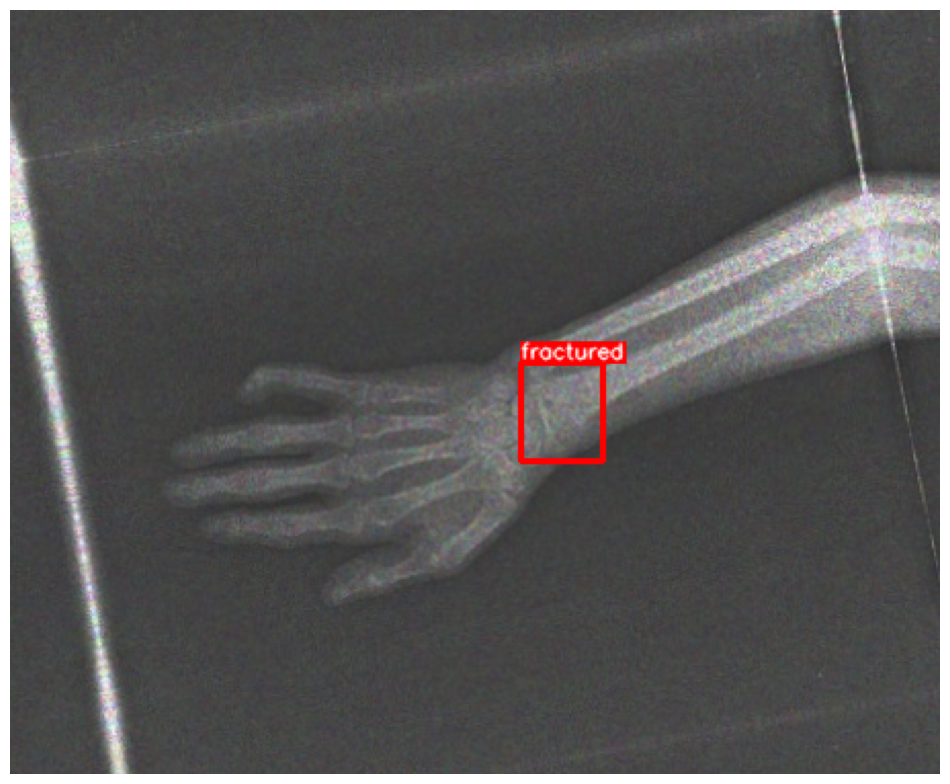

In [17]:
import os
import random

imgs = os.listdir('/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/Augmented_Set/images/')
img_aug = random.choice(imgs)
label_aug = img_aug[:img_aug.find('.')] + '.txt'
org_name = img_aug[:img_aug.find('_')]
img_org = img_aug[:img_aug.find('_')] + '.jpg'
label_org = org_name + '.txt'
print(img_aug, label_aug, img_org, label_org)

plot_image(label_dir='/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/data/Split-Authors/labels/train/' + label_org, 
img_dir='/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/data/Split-Authors/images/train/' + img_org)

plot_image(label_dir='/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/Augmented_Set/labels/' + label_aug, 
img_dir='/cluster/home/ammaa/Downloads/Ammars/Models/Fracture_Detection/YOLOV9/Augmented_Set/images/' + img_aug)